#GLASS

Bu notebook'ta, ahşap yüzeylerdeki anomalileri tespit etmek için bir *GLASS* modeli geliştirilecek ve eğitilecektir.

## 1. Ortam Kurulumu

### 1.1 Google Drive Bağlantısı

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


### 1.2 GLASS Deposunun Klonlanması

In [ ]:
!git clone https://github.com/gmzdag/wood-anomaly-detection.git

Cloning into 'GLASS'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 200 (delta 67), reused 56 (delta 56), pack-reused 123 (from 3)
Receiving objects: 100% (200/200), 8.23 MiB | 21.99 MiB/s, done.
Resolving deltas: 100% (104/104), done.


In [ ]:
%cd cd wood-anomaly-detection/models/GLASS/src

/content/drive/MyDrive/GLASS


### 1.3 Gerekli Kütüphanelerin Kurulumu

In [ ]:
!pip install imgaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 12.1 MB/s eta 0:00:00


In [ ]:
!pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 117.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


## 2. DTD'lerin Yüklenmesi

Anomali üretimi için kullanılacak DTD (Daha Fazla Dokulu Sözlük) veri setini hazırlanması.


In [ ]:
%cd datasets
!wget https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
!tar -xf dtd-r1.0.1.tar.gz
!rm dtd-r1.0.1.tar.gz

/content/drive/MyDrive/GLASS/datasets
--2025-05-18 08:00:59--  https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/dtd/dtd-r1.0.1.tar.gz [following]
--2025-05-18 08:00:59--  https://thor.robots.ox.ac.uk/dtd/dtd-r1.0.1.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625239812 (596M) [application/octet-stream]
Saving to: ‘dtd-r1.0.1.tar.gz’

dtd-r1.0.1.tar.gz   100%[===================>] 596.27M  29.1MB/s    in 25s     

2025-05-18 08:01:25 (23.8 MB/s) - ‘dtd-r1.0.1.tar.gz’ saved [625239812/625239812]



In [ ]:
%cd ..

##3. Model Eğitimi
GLASS modelinin ahşap veri seti üzerinde eğitilmesi.

**Parametre Açıklamaları:**

 - `--gpu:` Kullanılacak GPU'nun ID'si.
 - `--seed`: Rastgelelik için kullanılan tohum değeri. Bu, deneylerin tekrarlanabilirliğini sağlar.
 - `--test`: Test modunu etkinleştirir. Genellikle belirtilen bir checkpoint'ten (ckpt) yüklenen model ile test yapılır.
 - `net`: Model ile ilgili parametrelerin başlangıcını belirtir.
 - `-b`: Kullanılacak temel ağ (backbone network). Örnekte wideresnet50 kullanılıyor.
 - `-le`: Özellik çıkarımı için kullanılacak katman. Birden fazla belirtilebilir.
 - `--pretrain_embed_dimension`: Önceden eğitilmiş modelden çıkarılan gömülü vektörlerin (embeddings) boyutunu belirtir.
 - `--target_embed_dimension`: Hedef gömülü vektörlerin boyutunu belirtir.
 - `--patchsize`: İşlenecek görüntü yamalarının (patches) boyutu.
 - `--meta_epochs`: Meta-eğitim (meta-learning) fazındaki epoch sayısı.
 - `--eval_epochs`: Değerlendirme (evaluation) fazındaki epoch sayısı.
 - `--dsc_layers`: Diskriminatör (discriminator) ağındaki katman sayısı.
 - `--dsc_hidden`: Diskriminatör ağındaki gizli katmanların boyutu (nöron sayısı).
 - `--pre_proj`: Ön projeksiyonun kullanılıp kullanılmayacağını belirten flag veya değer.
 - `--mining`: Negatif örnek madenciliği (negative mining) stratejisinin kullanılıp kullanılmayacağını belirten flag veya değer.
 - `--noise`: Anomali ekleme veya eğitim sürecinde kullanılan gürültü (noise) miktarı.
 - `--radius`: Belirli bir algoritma veya strateji içinde kullanılan yarıçap değeri (örn. kümeleme, anomali tespiti kriteri).
 - `--p`: Olasılıkla ilgili bir parametre
 - `--step`: Bir adım boyutu .
 - `--limit`: Belirli bir sınırlama veya üst limit değeri.
 - `dataset`: Veri seti ile ilgili parametrelerin başlangıcını belirtir.
 - `--distribution`: Veri dağılımı ile ilgili bir parametre. Değer 0 olarak belirtilmiş.
 - `--mean`: Veri normalizasyonu veya işlenmesinde kullanılan ortalama (mean) değeri.
 - `--std`: Veri normalizasyonu veya işlenmesinde kullanılan standart sapma (standard deviation) değeri.
 - `--fg`: Genellikle ön plan (foreground) ile ilgili bir parametre. Değer 0 olarak belirtilmiş.
 - `--rand_aug`: Rastgele veri artırma yönteminin kullanılıp kullanılmayacağını belirten flag veya değer. Değer 1 olarak belirtilmiş, bu da kullanıldığı anlamına gelir.
 - `--batch_size`: Eğitim veya test sırasında kullanılacak veri yığınlarının (batch) boyutu.
 - `--resize`: Görüntülerin yeniden boyutlandırılacağı boyut.
 - `--imagesize`: İşlem görecek görüntülerin nihai boyutu.
  - `-d`: Kullanılacak veri setini ve ilgili yolları belirtir.
  - `wood`: Veri setinin spesifik bir objesi veya kategorisi (Ahşap).
  - `mvtec`: Kullanılan temel veri setinin adı.
  - `/content/drive/MyDrive/processed_dataset`: İşlenmiş veri setinin dosya yolu.
  - `/content/drive/MyDrive/GLASS/datasets/dtd/images`: Anomali üretimi için kullanılacak ek veri setinin (DTD) dosya yolu.

###3.1 10 Epoch İle Model Eğitimi

In [ ]:
!python main.py \
    --gpu 0 \
    --seed 0 \
    --test ckpt \
  net \
    -b wideresnet50 \
    -le layer2 \
    -le layer3 \
    --pretrain_embed_dimension 1536 \
    --target_embed_dimension 1536 \
    --patchsize 4 \
    --meta_epochs 10 \
    --eval_epochs 1 \
    --dsc_layers 2 \
    --dsc_hidden 1024 \
    --pre_proj 1 \
    --mining 1 \
    --noise 0.015 \
    --radius 0.75 \
    --p 0.5 \
    --step 20 \
    --limit 392 \
  dataset \
    --distribution 0 \
    --mean 0.5 \
    --std 0.1 \
    --fg 0 \
    --rand_aug 1 \
    --batch_size 8 \
    --resize 256 \
    --imagesize 256 -d wood mvtec /content/drive/MyDrive/processed_dataset /content/drive/MyDrive/wood-anomaly-detection/models/GLASS/src/datasets/dtd/images/

2025-05-18 10:02:41.118988: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 10:02:41.137265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747562561.159277   49799 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747562561.165728   49799 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-18 10:02:41.186846: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

###3.2 20 Epoch İle Model Eğitimi

In [ ]:
!python main.py \
    --gpu 0 \
    --seed 0 \
    --test ckpt \
  net \
    -b wideresnet50 \
    -le layer2 \
    -le layer3 \
    --pretrain_embed_dimension 1536 \
    --target_embed_dimension 1536 \
    --patchsize 4 \
    --meta_epochs 20 \
    --eval_epochs 1 \
    --dsc_layers 2 \
    --dsc_hidden 1024 \
    --pre_proj 1 \
    --mining 1 \
    --noise 0.015 \
    --radius 0.75 \
    --p 0.5 \
    --step 20 \
    --limit 392 \
  dataset \
    --distribution 0 \
    --mean 0.5 \
    --std 0.1 \
    --fg 0 \
    --rand_aug 1 \
    --batch_size 8 \
    --resize 256 \
    --imagesize 256 -d wood mvtec /content/drive/MyDrive/processed_dataset content/drive/MyDrive/wood-anomaly-detection/models/GLASS/src/datasets/dtd/images/

2025-05-18 10:07:38.127154: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 10:07:38.145110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747562858.166578   52838 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747562858.173082   52838 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-18 10:07:38.194465: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

###3.3 30 Epoch İle Model Eğitimi

In [ ]:
!python main.py \
    --gpu 0 \
    --seed 0 \
    --test ckpt \
  net \
    -b wideresnet50 \
    -le layer2 \
    -le layer3 \
    --pretrain_embed_dimension 1536 \
    --target_embed_dimension 1536 \
    --patchsize 4 \
    --meta_epochs 30 \
    --eval_epochs 1 \
    --dsc_layers 2 \
    --dsc_hidden 1024 \
    --pre_proj 1 \
    --mining 1 \
    --noise 0.015 \
    --radius 0.75 \
    --p 0.5 \
    --step 20 \
    --limit 392 \
  dataset \
    --distribution 0 \
    --mean 0.5 \
    --std 0.1 \
    --fg 0 \
    --rand_aug 1 \
    --batch_size 8 \
    --resize 256 \
    --imagesize 256 -d wood mvtec /content/drive/MyDrive/processed_dataset content/drive/MyDrive/wood-anomaly-detection/models/DRAEM/src/datasets/dtd/images/

2025-05-18 10:14:53.495884: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 10:14:53.513820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747563293.535463   58171 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747563293.542235   58171 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-18 10:14:53.564797: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

###3.4 50 Epoch İle Model Eğitimi

In [ ]:
!python main.py \
    --gpu 0 \
    --seed 0 \
    --test ckpt \
  net \
    -b wideresnet50 \
    -le layer2 \
    -le layer3 \
    --pretrain_embed_dimension 1536 \
    --target_embed_dimension 1536 \
    --patchsize 4 \
    --meta_epochs 50 \
    --eval_epochs 1 \
    --dsc_layers 2 \
    --dsc_hidden 1024 \
    --pre_proj 1 \
    --mining 1 \
    --noise 0.015 \
    --radius 0.75 \
    --p 0.5 \
    --step 20 \
    --limit 392 \
  dataset \
    --distribution 0 \
    --mean 0.5 \
    --std 0.1 \
    --fg 0 \
    --rand_aug 1 \
    --batch_size 8 \
    --resize 256 \
    --imagesize 256 -d wood mvtec /content/drive/MyDrive/processed_dataset /content/drive/MyDrive/GLASS/datasets/dtd/images

2025-05-18 10:42:27.592143: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 10:42:27.610352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747564947.632195   70436 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747564947.638831   70436 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-18 10:42:27.661202: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

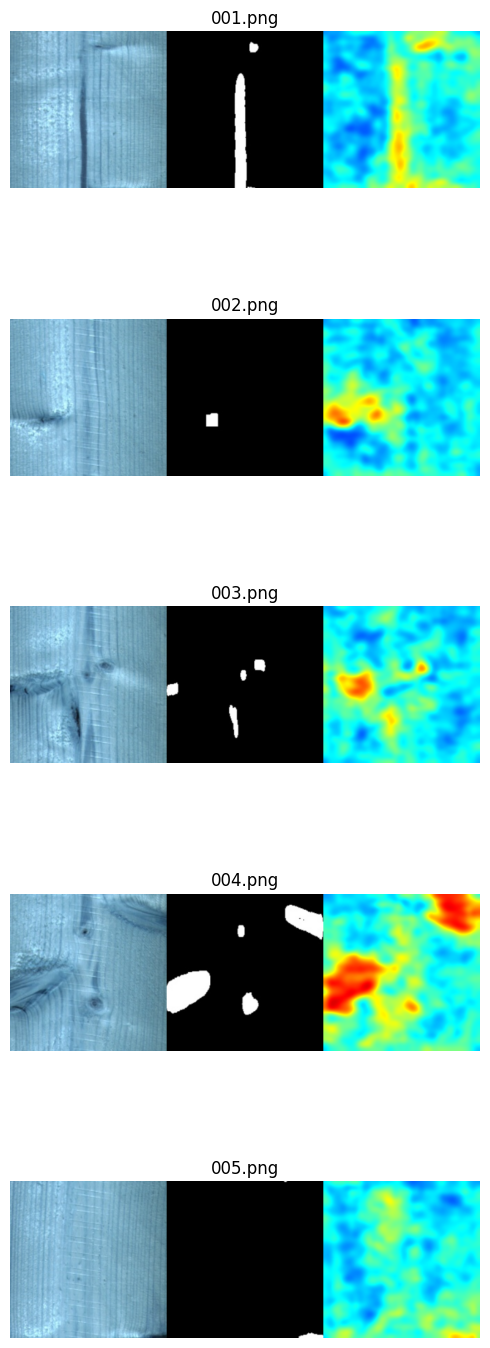

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

image_directory = '/content/drive/MyDrive/GLASS/results/eval/mvtec_wood'

image_files = [f for f in os.listdir(image_directory) if f.endswith('.png')]
image_files.sort()

selected_images = image_files[:5]

fig, axes = plt.subplots(len(selected_images), 1, figsize=(5, 15))

for i, image_file in enumerate(selected_images):
    image_path = os.path.join(image_directory, image_file)

    img = Image.open(image_path)

    axes[i].imshow(img)
    axes[i].set_title(image_file)
    axes[i].axis('off')

plt.tight_layout()
plt.show()